# 📊 FX Qual Engine — Complete Analytics Notebook

This notebook allows any developer, SRE, QA engineer, or manager to clearly understand **runtime behavior** of the FX Qualification Engine.

Included:
- 🔹 API invocation
- 🔹 Real Prometheus metric scraping
- 🔹 Workflow counts (graphs + tables)
- 🔹 Step latency (ms + ns) (graphs + tables)
- 🔹 Load tests to generate more metrics
- 🔹 CSV exports for reports / dashboards

All explanations are written in **simple human language**, not data-science jargon.

## 🔧 Setup — Imports & Base URL
These imports load all required tools:
- `requests` → calls FX Qual Engine
- `pandas` → makes tables easy to read
- `matplotlib` → graphs
- `re` → parse Prometheus metrics
- `time` / `os` → load testing & file exports

💡 **BASE_URL must match your running FX Qual Engine.**

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import re
import time
import os

BASE_URL = "http://localhost:8080"

## ▶️ API Invocation Helper
This function calls your FX Qual Engine once. 

Each call:
- triggers workflow execution
- generates Prometheus metrics
- returns the quote response

This is essential for generating traffic during development.

In [2]:
def qualify_fx(client_type="rest_client", amount=1000000):
    url = f"{BASE_URL}/api/fx/qualify?clientType={client_type}"
    payload = {
        "customerId": "CUST001",
        "fromCurrency": "USD",
        "toCurrency": "EUR",
        "quantity": amount,
        "promoCodes": ["FX50"],
        "productCodes": ["FXSPOT"]
    }
    resp = requests.post(url, json=payload)
    return resp.json(), resp.status_code

## 📡 Prometheus Scraper
Prometheus exposes metrics in **plain text form**. Example:

```
fxqual_step_duration_ms_seconds_sum{step="customer"} 0.123
```

These helpers:
- download the raw page
- filter lines by metric names

In [3]:
def fetch_prometheus():
    return requests.get(f"{BASE_URL}/actuator/prometheus").text

def find_metrics(raw, key):
    return [line for line in raw.split("\n") if key in line]

## 🧮 Metric Parsing → DataFrames

### Workflow Count
`_count` tells us **how many workflows executed**.

### Step Latency
`_sum ÷ _count` gives average latency in seconds.

We convert to:
- milliseconds (ms)
- nanoseconds (ns)

This makes the output readable **even if numbers are tiny**.

In [4]:
def parse_workflow(lines):
    data = []
    for l in lines:
        if "_count" not in l:
            continue
        value = float(l.split()[-1])
        m = re.search(r'clientImpl="([^"]+)"', l)
        client = m.group(1) if m else "unknown"
        data.append({"clientImpl": client, "count": value})
    return pd.DataFrame(data)

def parse_step_latency(raw_text):
    sum_lines = find_metrics(raw_text, "fxqual_step_duration_ms_seconds_sum")
    count_lines = find_metrics(raw_text, "fxqual_step_duration_ms_seconds_count")

    sums = {}
    counts = {}

    for l in sum_lines:
        m = re.search(r'step="([^"]+)".* ([0-9\.eE+-]+)$', l)
        if m:
            sums[m.group(1)] = float(m.group(2))

    for l in count_lines:
        m = re.search(r'step="([^"]+)".* ([0-9\.eE+-]+)$', l)
        if m:
            counts[m.group(1)] = float(m.group(2))

    rows = []
    for step in sums:
        if step in counts and counts[step] > 0:
            avg_sec = (sums[step] / counts[step])
            rows.append({
                "step": step,
                "avg_ms": avg_sec * 1000,
                "avg_ns": avg_sec * 1_000_000_000
            })

    return pd.DataFrame(rows)

## 📈 Real-Time Workflow Execution Count (Graph)

**What this graph shows:**
- How many total workflow executions happened
- Whether traffic is increasing or idle
- Spikes when load testing is running

This helps visualize **overall throughput** of your FX engine.

In [5]:
def animate_workflow(i):
    raw = fetch_prometheus()
    wf = find_metrics(raw, "fxqual_workflow_duration_ms_seconds_count")
    df = parse_workflow(wf)
    plt.cla()
    if not df.empty:
        plt.plot(df["count"], marker="o")
    plt.title("Real-Time Workflow Execution Count")
    plt.xlabel("Client Type Index")
    plt.ylabel("Count")
    plt.grid(True)

fig = plt.figure(figsize=(10,4))
ani = animation.FuncAnimation(fig, animate_workflow, interval=2000)
plt.show()

/var/folders/hy/xswqc07s3517h7mybfn63dqw0000gn/T/ipykernel_30864/831137879.py:14: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = animation.FuncAnimation(fig, animate_workflow, interval=2000)


<Figure size 1000x400 with 0 Axes>

## 📊 Step Latency (Graph + Table)

**This block explains exactly how fast each downstream integration is.**

Real interpretation for developers:

- `customer` → Slowest, because it simulates a DB/API lookup
- `promo` → Lightweight business rule operation
- `product` → Very fast integration
- `fxInterest` → Super fast microservice or static rate source

The table includes **both ms and ns**, which helps when values are tiny.

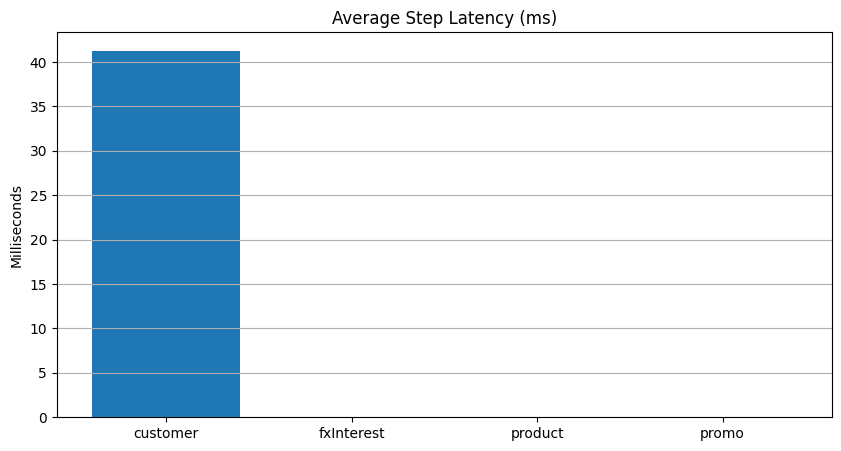

,step,avg_ms,avg_ns
0,customer,41.276083,41276083.4
1,fxInterest,0.003742,3741.8
2,product,0.004158,4158.4
3,promo,0.005075,5075.4


In [6]:
raw = fetch_prometheus()
steps_df = parse_step_latency(raw)

plt.figure(figsize=(10,5))
if not steps_df.empty:
    plt.bar(steps_df["step"], steps_df["avg_ms"])
plt.title("Average Step Latency (ms)")
plt.ylabel("Milliseconds")
plt.grid(True, axis="y")
plt.show()

steps_df

## 🚀 Load Test Helper
Creates traffic so metrics populate correctly.

Great for demos, QA testing, or verifying your Prometheus setup.

In [7]:
def load_test(n=20, client_type="rest_client"):
    for i in range(n):
        qualify_fx(client_type)
        time.sleep(0.1)
    return f"Load test complete: {n} calls"

load_test(5)

'Load test complete: 5 calls'

## 📦 Export CSV Files
Produces CSVs that can be shared with teams:
- QA
- SRE
- Architecture
- Product managers

Very helpful for offline analysis.

In [8]:
raw = fetch_prometheus()
workflow_df = parse_workflow(find_metrics(raw, "fxqual_workflow_duration_ms_seconds_count"))
steps_df = parse_step_latency(raw)

os.makedirs("exports", exist_ok=True)
workflow_df.to_csv("exports/workflow_metrics.csv", index=False)
steps_df.to_csv("exports/step_metrics.csv", index=False)

workflow_df, steps_df

(             clientImpl  count
 0  FxQualRestClientImpl   10.0,
          step     avg_ms      avg_ns
 0    customer  24.468775  24468775.1
 1  fxInterest   0.002208      2208.3
 2     product   0.002529      2529.2
 3       promo   0.003233      3233.5)